In [1]:
using Plots, Distributions, Statistics, DifferentialEquations, Optim, JLD, LaTeXStrings, ProgressMeter

print("Packages imported. \n\n")

mutable struct Network
    Grid::Matrix{Bool} # 0: Susceptible, 1: Infected
    N::Int64 # Grid size
    β::Float64 # Infection rate
    γ::Float64 # Recovery rate
    LAWeight::Float64 # Local Awareness Weight
    GAWeight::Float64 # Global Awareness Weight
    AEWeight::Float64 # Awareness Effect Weight
end

function InitializeNetwork(N::Int64, I₀::Float64, β::Float64, γ::Float64, LAWeight::Float64, GAWeight::Float64, AEWeight::Float64)
    if I₀ > 1 || I₀ < 0
        error("I₀ must be between 0 and 1")
    elseif β > 1 || β < 0
        error("β must be between 0 and 1")
    elseif γ > 1 || γ < 0
        error("γ must be between 0 and 1")
    elseif LAWeight + GAWeight != 1
        error("LAWeight + GAWeight must be 1")
    elseif LAWeight < 0 || GAWeight < 0
        error("LAWeight and GAWeight must be positive")
    elseif AEWeight > 1 || AEWeight < 0
        error("AEWeight must be between 0 and 1")
    end

    Grid = zeros(Bool, N, N)
    for node ∈ eachindex(Grid)
        if rand() < I₀
            Grid[node] = 1
        end
    end
    return Network(Grid, N, β, γ, LAWeight, GAWeight, AEWeight)
end

# Get neighbors of a node
function GetNeighbors(Network::Network, node::CartesianIndex)
    dim = Network.N
    i, j = Tuple(node)
    neighbors = [[1 + i % dim, j], [i, 1 + j % dim], [(-2 + i + dim) % dim + 1, j], [i, (-2 + j + dim) % dim + 1]]
    return neighbors
end

# SIS epidemic dynamics
function SIS!(Network::Network) # With Awareness
    for node ∈ CartesianIndices(Network.Grid)
        if Network.Grid[node] && rand() < Network.γ
            Network.Grid[node] = 0
        end
    end
    GlobalAwareness = sum(Network.Grid) / Network.N^2
    for node ∈ CartesianIndices(Network.Grid)
        if !Network.Grid[node]
            Neighbors = GetNeighbors(Network, node)
            LocalAwareness = sum([Network.Grid[neighbor...] for neighbor ∈ Neighbors]) / 4
            TotalAwareness = Network.LAWeight * LocalAwareness + Network.GAWeight * GlobalAwareness
            AwarenessEffect = 1 - Network.AEWeight * TotalAwareness
            for neighbor ∈ Neighbors
                if Network.Grid[neighbor...] && rand() < Network.β * AwarenessEffect
                    Network.Grid[node] = 1
                    break
                end
            end
        end
    end
end

function GetSample(N::Int64, I₀::Float64, β::Float64, γ::Float64, LAWeight::Float64, GAWeight::Float64, AEWeight::Float64; δ::Float64=0.2)
    TheNetwork = InitializeNetwork(N, I₀, β, γ, LAWeight, GAWeight, AEWeight)
    I_Density = Float64[I₀]
    while true
        SIS!(TheNetwork)
        push!(I_Density, mean(TheNetwork.Grid))
        if length(I_Density) > 50 && std(I_Density[end-50:end]) < δ
            break
        end
    end
    return I_Density
end

function GetAvgTS(SampleSize::Int; N::Int64=100, I₀::Float64=0.1, β::Float64=0.1, γ::Float64=0.15, LAWeight::Float64=0.5, GAWeight::Float64=0.5, AEWeight::Float64=0.5)
    Samples = [GetSample(N, I₀, β, γ, LAWeight, GAWeight, AEWeight) for _ ∈ 1:SampleSize]
    ComT = minimum(length.(Samples))
    AvgI_den = [mean([Samples[i][j] for i ∈ 1:SampleSize]) for j ∈ 1:ComT]
    return AvgI_den
end

function SISODE(du, u, p, t)
    β, γ = p
    du[1] = -β * u[1] * u[2] + γ * u[2]
    du[2] = β * u[1] * u[2] - γ * u[2]
end

function cost_function(params, data)
    ode_prob = ODEProblem(SISODE, [1 - data[1], data[1]], (1, length(data)), params)
    solution = solve(ode_prob, saveat=1:length(data))
    model_data = solution[2, :]  # Assuming infected population is the second variable

    return sum((model_data - data) .^ 2)
end

function GetOptPars(params_guess::Vector{Float64}, AvgI_dens::Vector{Float64})
    result = optimize(params -> cost_function(params, AvgI_dens), params_guess, NelderMead())
    params_optimized = Optim.minimizer(result)
    return params_optimized
end

print("Functions and modules defined.\n\n")

# Constant Parameters
N = 100
I₀ = 0.1
β = 0.1
γ = 0.15

# Variable Parameters
LAWeight = 0.5
GAWeight = 0.5
AEWeight = 0.5

print("Parameters initialized. \n")

Packages imported. 

Functions and modules defined.

Parameters initialized. 


In [3]:
TheNetwork = InitializeNetwork(N, I₀, β, γ, LAWeight, GAWeight, 0.0)
NoAwarenessAnimation = Animation()
for _ ∈ 1:50
    SIS!(TheNetwork)
    heatmap(TheNetwork.Grid, c=cgrad([:white, :red]), size=(600, 500),
        colorbar=false, xaxis=false, yaxis=false, title="No Awareness", frame=:box)
    frame(NoAwarenessAnimation)
end
gif(NoAwarenessAnimation, "NoAwareness.gif")

TheNetwork = InitializeNetwork(N, I₀, β, γ, LAWeight, GAWeight, 0.5)
AwarenessAnimation = Animation()
for _ ∈ 1:50
    SIS!(TheNetwork)
    heatmap(TheNetwork.Grid, c=cgrad([:white, :red]), size=(600, 500),
        colorbar=false, xaxis=false, yaxis=false, title="With Awareness", frame=:box)
    frame(AwarenessAnimation)
end
gif(AwarenessAnimation, "Awareness.gif")

TheNetwork = InitializeNetwork(N, I₀, β, γ, LAWeight, GAWeight, 1.0)
FullAwarenessAnimation = Animation()
for _ ∈ 1:50
    SIS!(TheNetwork)
    heatmap(TheNetwork.Grid, c=cgrad([:white, :red]), size=(600, 500),
        colorbar=false, xaxis=false, yaxis=false, title="Full Awareness", frame=:box)
    frame(FullAwarenessAnimation)
end
gif(FullAwarenessAnimation, "FullAwareness.gif");

[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Network-Science-Project\NoAwareness.gif
[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Network-Science-Project\Awareness.gif
[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Network-Science-Project\FullAwareness.gif


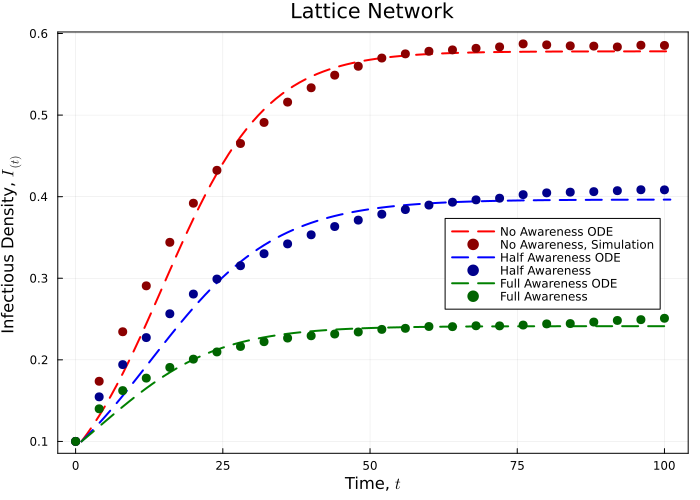

In [58]:
TheNetwork = InitializeNetwork(500, I₀, β, γ, LAWeight, GAWeight, 0.0)
NoAwareness_Is = Float64[I₀]
for _ ∈ 1:100
    SIS!(TheNetwork)
    push!(NoAwareness_Is, mean(TheNetwork.Grid))
end

TheNetwork = InitializeNetwork(500, I₀, β, γ, LAWeight, GAWeight, 0.5)
Awareness_Is = Float64[I₀]
for _ ∈ 1:100
    SIS!(TheNetwork)
    push!(Awareness_Is, mean(TheNetwork.Grid))
end

TheNetwork = InitializeNetwork(500, I₀, β, γ, LAWeight, GAWeight, 1.0)
FullAwareness_Is = Float64[I₀]
for _ ∈ 1:100
    SIS!(TheNetwork)
    push!(FullAwareness_Is, mean(TheNetwork.Grid))
end

TimeSeriesData = Dict("NoAwareness" => NoAwareness_Is, "Awareness" => Awareness_Is, "FullAwareness" => FullAwareness_Is)
save("TimeSeriesData-Grid.jld", TimeSeriesData)
TimeSeriesData = load("TimeSeriesData-Grid.jld")
NoAwareness_Is = TimeSeriesData["NoAwareness"]
Awareness_Is = TimeSeriesData["Awareness"]
FullAwareness_Is = TimeSeriesData["FullAwareness"]

params_guess = [β, γ]

NA_OptPars = GetOptPars(params_guess, NoAwareness_Is)
A_OptPars = GetOptPars(params_guess, Awareness_Is)
FA_OptPars = GetOptPars(params_guess, FullAwareness_Is)

ode_prob = ODEProblem(SISODE, [1 - NoAwareness_Is[1], NoAwareness_Is[1]], (1, length(NoAwareness_Is)), NA_OptPars)
NA_Sol = solve(ode_prob, saveat=1:length(NoAwareness_Is))[2, :]

ode_prob = ODEProblem(SISODE, [1 - Awareness_Is[1], Awareness_Is[1]], (1, length(Awareness_Is)), A_OptPars)
A_Sol = solve(ode_prob, saveat=1:length(Awareness_Is))[2, :]

ode_prob = ODEProblem(SISODE, [1 - FullAwareness_Is[1], FullAwareness_Is[1]], (1, length(FullAwareness_Is)), FA_OptPars)
FA_Sol = solve(ode_prob, saveat=1:length(FullAwareness_Is))[2, :]

TimeSeriesPlot = begin
    plot(NA_Sol, label="No Awareness ODE", lw=2, lc=:red, ls=:dash)
    scatter!(0:4:100, NoAwareness_Is[1:4:end], label="No Awareness, Simulation", ms=5, msw=0, c=:darkred)
    plot!(A_Sol, label="Half Awareness ODE", lw=2, lc=:blue, ls=:dash)
    scatter!(0:4:100, Awareness_Is[1:4:end], label="Half Awareness", ms=5, msw=0, c=:darkblue)
    plot!(FA_Sol, label="Full Awareness ODE", lw=2, lc=:green, ls=:dash)
    scatter!(0:4:100, FullAwareness_Is[1:4:end], label="Full Awareness", ms=5, msw=0, c=:darkgreen)
    plot!(xlabel="Time, " * L"t", ylabel="Infectious Density, " * L"I_{(t)}", title="Lattice Network", size=(700, 500), frame=:box, legend=5)
end
savefig(TimeSeriesPlot, "TimeSeriesPlot-Grid.png")

display(TimeSeriesPlot)

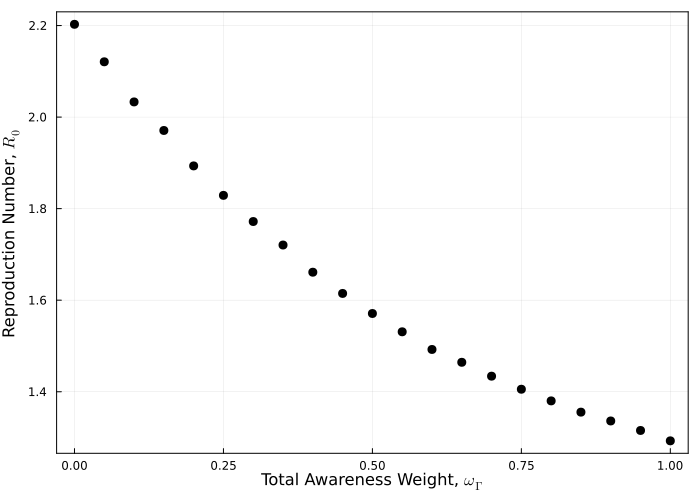

In [57]:
params_guess = [β, γ]
AEWs = 0.0:0.05:1.0
AEPars = Vector[]
@showprogress for AEW ∈ AEWs
    AvgI_dens = GetAvgTS(50; AEWeight=AEW)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    push!(AEPars, params_optimized)
end

AwarenessEffectPlot = scatter(AEWs, first.(AEPars) ./ last.(AEPars), ms=5, c=:black, label=false,
    xlabel="Total Awareness Weight, " * L"\omega_\Gamma", ylabel="Reproduction Number, " * L"R_0", size=(700, 500), frame=:box)
savefig(AwarenessEffectPlot, "AE-R0-Grid.png")
display(AwarenessEffectPlot)

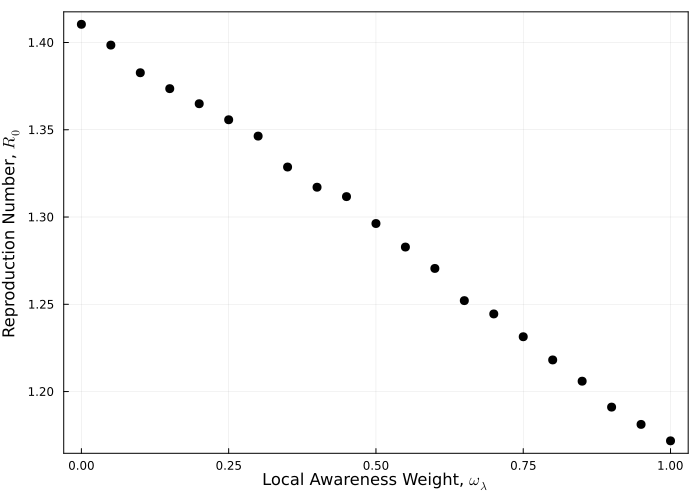

In [56]:
LAWs = 0.0:0.05:1.0
LAPars = Vector[]
@showprogress for LAW ∈ LAWs
    AvgI_dens = GetAvgTS(50; LAWeight=LAW, GAWeight=1 - LAW, AEWeight=1.0)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    push!(LAPars, params_optimized)
end

LocalAwarenessPlot = scatter(LAWs, first.(LAPars) ./ last.(LAPars), ms=5, c=:black, label=false,
    xlabel="Local Awareness Weight, " * L"\omega_\lambda", ylabel="Reproduction Number, " * L"R_0", size=(700, 500), frame=:box)
savefig(LocalAwarenessPlot, "LAW-R0-Grid.png")
display(LocalAwarenessPlot)

In [3]:
params_guess = [β, γ]
Effects = 0.0:0.035:1.0
CrosAwareness = zeros(length(Effects), length(Effects), 3)
@showprogress for index ∈ CartesianIndices(CrosAwareness)
    i, j = Tuple(index)
    AEW = Effects[i]
    LAW = Effects[j]
    AvgI_dens = GetAvgTS(7; LAWeight=LAW, GAWeight=1 - LAW, AEWeight=AEW)
    params_optimized = GetOptPars(params_guess, AvgI_dens)
    CrosAwareness[i, j, :] = [params_optimized; params_optimized[1] / params_optimized[2]]
end
save("CrosAwareness-Grid.jld", Dict("AEW" => Effects, "LAW" => Effects, "CrosAwareness" => CrosAwareness))

Progress: 100%|█████████████████████████████████████████| Time: 2:29:489mm


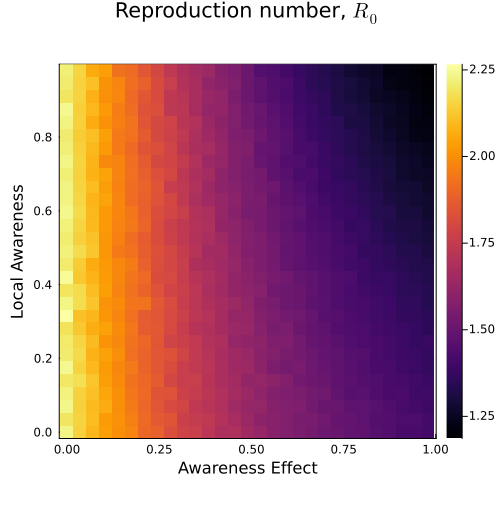

In [53]:
CrossR0Plot = heatmap(Effects, Effects, CrosAwareness[:, :, 3]', size=(500, 520), frame=:box, ratio=:equal,
    xlabel="Awareness Effect", ylabel="Local Awareness Weight, " * L"\lambda", title="Reproduction number, " * L"R_0")
savefig(CrossR0Plot, "CrossR0Plot-Grid.png")
display(CrossR0Plot)

In [27]:
(LAPars[end][1] / LAPars[end][2]) - (LAPars[1][1] / LAPars[1][2])

-0.23864619591782987